In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

from skimage import (
    color, feature, filters, measure, morphology, segmentation, util
)

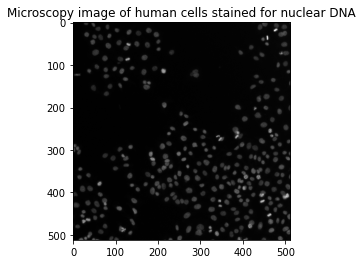

In [6]:
from skimage.data import human_mitosis

image = human_mitosis()

fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
ax.set_title('Microscopy image of human cells stained for nuclear DNA')
plt.show()

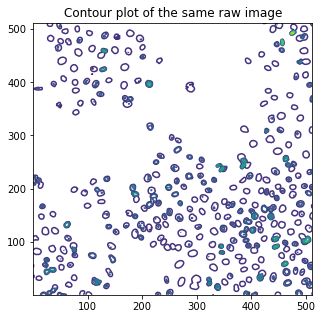

In [7]:
# Another way of visualizing a greyscale image is contour plotting:
fig, ax = plt.subplots(figsize=(5, 5))
qcs = ax.contour(image, origin='image')
ax.set_title('Contour plot of the same raw image')
plt.show()

In [8]:
#The contour lines are drawn at these levels:
qcs.levels

array([  0.,  40.,  80., 120., 160., 200., 240., 280.])

In [9]:
#Each level has, respectively, the following number of segments:
[len(seg) for seg in qcs.allsegs]

[0, 320, 270, 48, 19, 3, 1, 0]

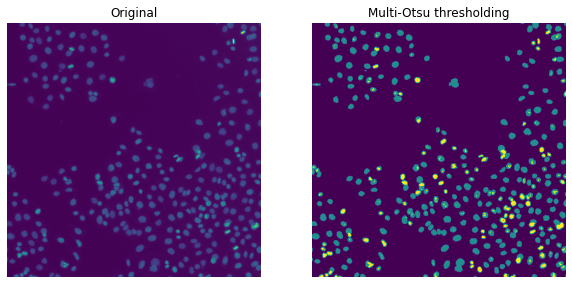

In [11]:
#Estimate the mitotic index

thresholds = filters.threshold_multiotsu(image, classes=3)
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(regions)
ax[1].set_title('Multi-Otsu thresholding')
ax[1].axis('off')
plt.show()

In [23]:
#Since there are overlapping nuclei, thresholding is not enough to segment all the nuclei. If it were, we could readily compute a mitotic index for this sample:
cells = image > thresholds[0]
dividing = image > thresholds[1]
labeled_cells = measure.label(cells)
labeled_dividing = measure.label(dividing)

naive_mi = (labeled_dividing.max() / labeled_cells.max())*100
print(naive_mi)

78.47222222222221


In [15]:
#Whoa, this can’t be! The number of dividing nuclei is overestimated, 

print(labeled_dividing.max())

#while the total number of cells,is underestimated.
print(labeled_cells.max())

226
288


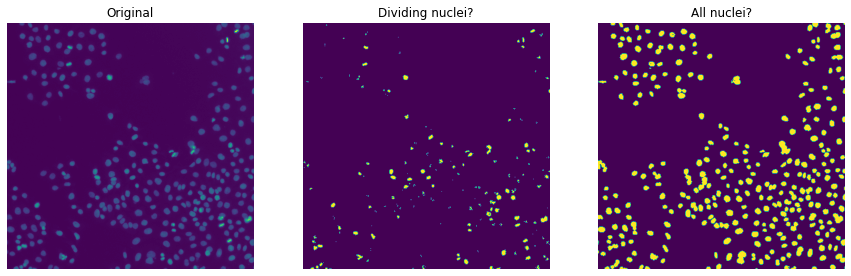

In [16]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title('Original')
ax[0].axis('off')
ax[2].imshow(cells)
ax[2].set_title('All nuclei?')
ax[2].axis('off')
ax[1].imshow(dividing)
ax[1].set_title('Dividing nuclei?')
ax[1].axis('off')
plt.show()

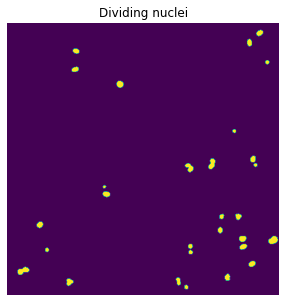

29


In [18]:
#Count dividing nuclei

higher_threshold = 125
dividing = image > higher_threshold

smoother_dividing = filters.rank.mean(util.img_as_ubyte(dividing),
                                      morphology.disk(4))

binary_smoother_dividing = smoother_dividing > 20

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(binary_smoother_dividing)
ax.set_title('Dividing nuclei')
ax.axis('off')
plt.show()

#get number of dividing nuclei
cleaned_dividing = measure.label(binary_smoother_dividing)
print(cleaned_dividing.max())


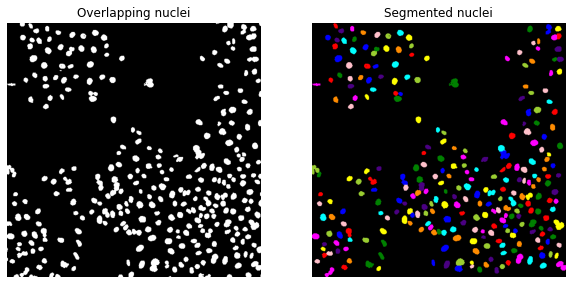

In [19]:
#Segment nuclei
distance = ndi.distance_transform_edt(cells)

local_max_coords = feature.peak_local_max(distance, min_distance=7)
local_max_mask = np.zeros(distance.shape, dtype=bool)
local_max_mask[tuple(local_max_coords.T)] = True
markers = measure.label(local_max_mask)

segmented_cells = segmentation.watershed(-distance, markers, mask=cells)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(cells, cmap='gray')
ax[0].set_title('Overlapping nuclei')
ax[0].axis('off')
ax[1].imshow(color.label2rgb(segmented_cells, bg_label=0))
ax[1].set_title('Segmented nuclei')
ax[1].axis('off')
plt.show()

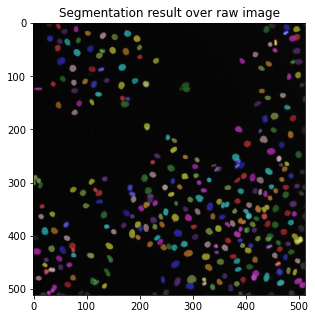

In [20]:
#Additionally, we may use function color.label2rgb to overlay the original image with the segmentation result, using transparency (alpha parameter).
color_labels = color.label2rgb(segmented_cells, image, alpha=0.4, bg_label=0)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(color_labels)
ax.set_title('Segmentation result over raw image')
plt.show()

In [30]:
#Finally, we find a total number of cells in this sample.

print(segmented_cells.max())

# Therefore, we estimate the mitotic index to be:

print((cleaned_dividing.max() / segmented_cells.max())*100)

286
10.13986013986014
